In [1]:
import os
import argparse
import functools
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

import utils
import dataset_utils
import convlstm_model

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
def input_fn(data_dir, subset, batch_size,
             use_distortion_for_training=True):
    use_distortion = subset == 'train' and use_distortion_for_training
    dataset = dataset_utils.ConvLSTMDataSet(data_dir, subset, use_distortion)
    return dataset.make_batch(batch_size)

In [4]:
data_dir = '../data_patch'
batch_size = 32
epochs = 20

In [5]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, ConvLSTM2D, Activation, BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import backend as K

In [6]:
def create_model(input_tensor):
    inputs = Input(tensor=input_tensor)
    x = inputs
    x = ConvLSTM2D(filters=128, kernel_size=(3,3), padding='same', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=1, kernel_size=(3,3), padding='same', return_sequences=False)(x)
    x = BatchNormalization()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [13]:
def loss(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)
    return tf.losses.mean_squared_error(y_true, y_pred)

In [16]:
K.clear_session()
TRAIN_STEPS_PER_EPOCH = dataset_utils.ConvLSTMDataSet.num_examples_per_epoch('train') // batch_size
VAL_STEPS_PER_EPOCH = dataset_utils.ConvLSTMDataSet.num_examples_per_epoch('val') // batch_size

#Get your datatensors
train_inputs, train_labels = input_fn(data_dir, 'train', batch_size)
val_inputs, val_labels = input_fn(data_dir, 'val', batch_size)

shuffle dataset


In [17]:
train_model = create_model(train_inputs)
train_model.compile(optimizer='adam',
                    loss=loss,
                    metrics=[loss],
                    target_tensors=[train_labels])
train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 32, 32, 1)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 14, 32, 32, 128)   594944    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 32, 32, 128)   512       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 14, 32, 32, 64)    442624    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 32, 32, 64)    256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 14, 32, 32, 64)    295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 32, 32, 64)    256       
__________

In [19]:
val_model = create_model(val_inputs)
val_model.compile(optimizer='adam',
                  loss=loss,
                  metrics=[loss],
                  target_tensors=[val_labels])
val_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 14, 32, 32, 1)     0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 14, 32, 32, 128)   594944    
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 32, 32, 128)   512       
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 14, 32, 32, 64)    442624    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 32, 32, 64)    256       
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 14, 32, 32, 64)    295168    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 32, 32, 64)    256       
__________

In [20]:
class EvaluateInputTensor(Callback):

    def __init__(self, model, steps, metrics_prefix='val', verbose=1):
        # parameter of callbacks passed during initialization
        # pass evalation mode directly
        super(EvaluateInputTensor, self).__init__()
        self.val_model = model
        self.num_steps = steps
        self.verbose = verbose
        self.metrics_prefix = metrics_prefix

    def on_epoch_end(self, epoch, logs={}):
        self.val_model.set_weights(self.model.get_weights())
        results = self.val_model.evaluate(None, None, steps=int(self.num_steps),
                                          verbose=self.verbose)
        metrics_str = '\n'
        for result, name in zip(results, self.val_model.metrics_names):
            metric_name = self.metrics_prefix + '_' + name
            logs[metric_name] = result
            if self.verbose > 0:
                metrics_str = metrics_str + metric_name + ': ' + str(result) + ' '

        if self.verbose > 0:
            print(metrics_str)

In [21]:
sess = K.get_session()

In [22]:
history = train_model.fit(
    epochs=epochs,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    callbacks=[EvaluateInputTensor(val_model, steps=VAL_STEPS_PER_EPOCH)])

Epoch 1/20
43/43 [==============================] - 10s 232ms/step

val_loss: 0.11000205489785173 val_loss_1: 0.11000205489785173 
628/628 [==============================] - 426s 678ms/step - loss: 0.1784 - loss_1: 0.1784
Epoch 2/20
43/43 [==============================] - 9s 213ms/step

val_loss: 0.10727929930354274 val_loss_1: 0.10727929930354274 
628/628 [==============================] - 419s 668ms/step - loss: 0.1038 - loss_1: 0.1038
Epoch 3/20
43/43 [==============================] - 9s 212ms/step

val_loss: 0.10733788235242976 val_loss_1: 0.10733788235242976 
628/628 [==============================] - 419s 667ms/step - loss: 0.1034 - loss_1: 0.1034
Epoch 4/20
43/43 [==============================] - 9s 212ms/step

val_loss: 0.10738845238851946 val_loss_1: 0.10738845238851946 
628/628 [==============================] - 418s 666ms/step - loss: 0.1039 - loss_1: 0.1039
Epoch 5/20
43/43 [==============================] - 9s 212ms/step

val_loss: 0.10728309216887452 val_loss_1: 0.1072

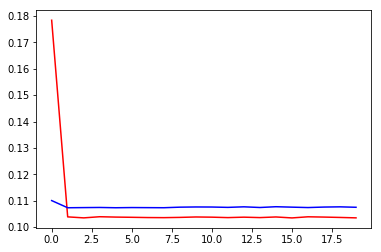

In [23]:
plt.plot(history.history['loss'], color='r', label='train_loss')
plt.plot(history.history['val_loss'], color='b', label='val_loss')